In [ ]:

!pip install tf-keras-vis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 968.1 kB/s eta 0:00:00


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import tensorflow as tf
from tf_keras_vis.gradcam import Gradcam
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16 as Model
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
%matplotlib inline

In [ ]:
# загружаем предварительно обученную модель VGG16 с весами, обученными на ImageNet
from tensorflow.keras.applications.vgg16 import VGG16 as Model
model = Model(weights='imagenet', include_top=True)
# и отобразим описание модели
model.summary()

553467096/553467096 [==============================] - 7s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
# загрузим несколько изображений и выполним их предварительную обработку
# перед использованием их в нашей модели
img = load_img('car.jpeg', target_size=(224, 224))
img1 = load_img('car1.jpeg', target_size=(224, 224))
img2 = load_img('car2.jpeg', target_size=(224, 224))
img3 = load_img('truck.jpeg', target_size=(224, 224))
images = np.asarray([np.array(img), np.array(img1), np.array(img2), np.array(img3)])
X = preprocess_input(images)

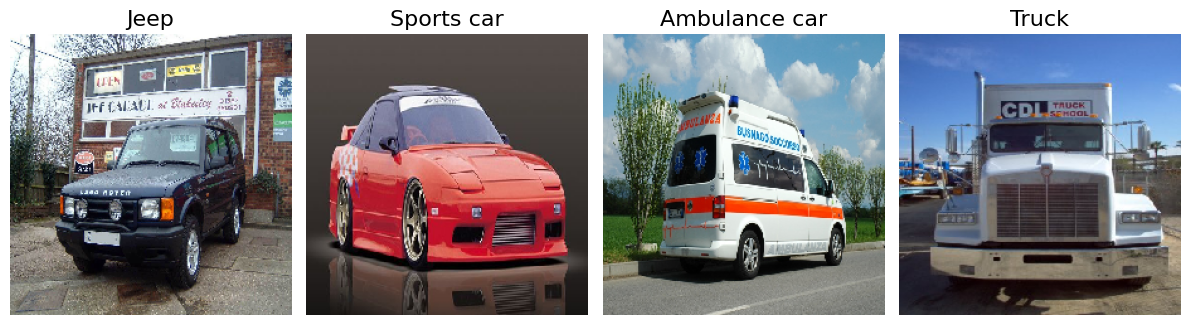

In [ ]:
# отобразим загруженные изображения
img_titles = ['Jeep', 'Sports car', 'Ambulance car', 'Truck']
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(img_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('original.png')
plt.show()

In [ ]:
# создаем модификатор модели и функцию оценки для исползьвания с
# визуализацией tf_keras_vis
# заменяем активацию последнего слоя модели на линейную функцию, которая
# указывает классы для визуализации
replace2linear = ReplaceToLinear()
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear
score = CategoricalScore([609, 817, 407, 867])
def score_function(output):
    return (output[0][609], output[1][817], output[2][407], output[3][867])

In [ ]:
# загрузим сайленси карты
saliency = Saliency(model,model_modifier=replace2linear,clone=True)
saliency_map = saliency(score, X)

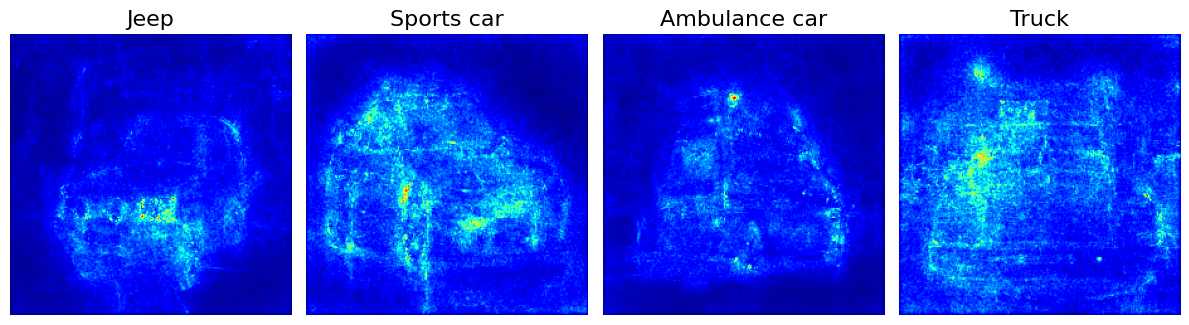

In [ ]:
# отобразим изображения с картой сайленси, чтобы увидеть, какие части
# изображений вносят наибольший вклад в принятие решения
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(img_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('saliency.png')
plt.show()

In [ ]:
# теперь используем метод SmoothGrad Для уменьшения шума на кмайленси картах
saliency_map = saliency(score,X,smooth_samples=20,smooth_noise=0.20)

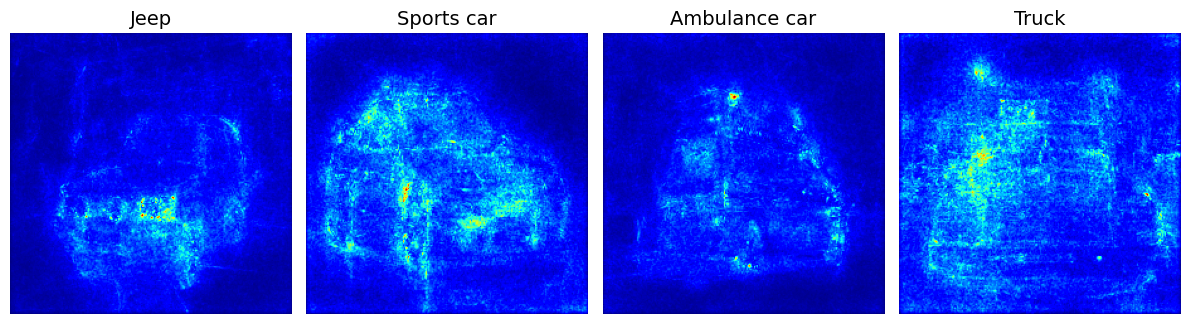

In [ ]:
# отобразим изображения и сохраним графическое представление в отдельное
# изображение
saliency_map = saliency(score,X,smooth_samples=20,smooth_noise=0.20)
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(img_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('sgrad.png')
plt.show()

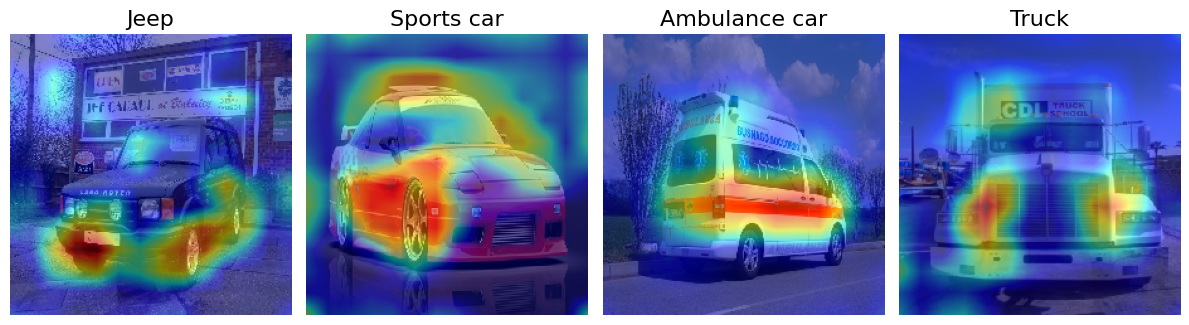

In [ ]:
# далее используем метод Grad-CAM для визуализации активаций
# нейросети относительно заданных классов
# так мы опять же сможем увидетьобласти изображения, котрые
# модель считает важными для определения классов
gradcam = Gradcam(model,model_modifier=replace2linear,clone=True)
cam = gradcam(score,X,penultimate_layer=-1)
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(img_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :4] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('gcam.png')
plt.show()

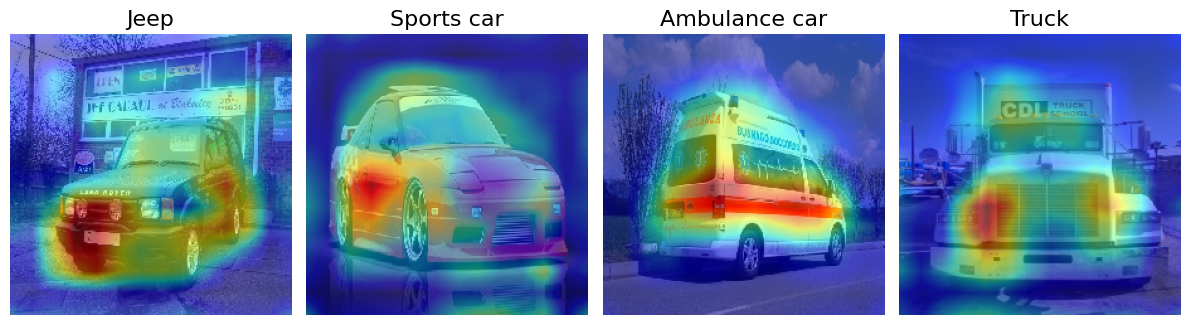

In [ ]:
# используем улучшенную версию Grad-CAM - CradCAM++, который
# имеет улучшенный алгоритм для визуализации активаций
# этот метод позволяет более точно выделить области изображения,
# которые модель считает важными для определения классов
gradcam = GradcamPlusPlus(model,model_modifier=replace2linear,clone=True)
cam = gradcam(score,X,penultimate_layer=-1)
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(img_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :4] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('gcampp.png')
plt.show()